#INITIAL SET UP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# DATA LOADING

In [ ]:
# Load the dataset
dataset = np.load('/content/drive/MyDrive/Challenge1/extracted_data/public_data.npz', allow_pickle=True)

print(dataset.files)

['data', 'labels']


In [ ]:
# Extract the arrays from the data
data = dataset['data']
labels = dataset['labels']

# Convert data and labels values into the correct data_type
data = np.array(data, dtype=np.uint8)

print(data.shape) #the images
print(labels.shape)

(5200, 96, 96, 3)
(5200,)


# DATA SET PREPARATION

In [ ]:
# Remove duplicates

def get_image_hash(image):
    # Converti l'immagine in una stringa
    image_string = image.tobytes()

    # Calcola la somma dei valori dei byte
    hash_value = sum(image_string)

    return hash_value

# Compute hash for each image
hashes = np.array([get_image_hash(image) for image in data])

# Find unique hashes and their indices
unique_hashes, indices = np.unique(hashes, return_index=True)

# Select the unique images and their corresponding labels
data_unique = data[indices]
labels_unique = labels[indices]


print(f"Original dataset size: {data.shape[0]}")
print(f"Unique dataset size: {data_unique.shape[0]}")

Original dataset size: 5200
Unique dataset size: 4849


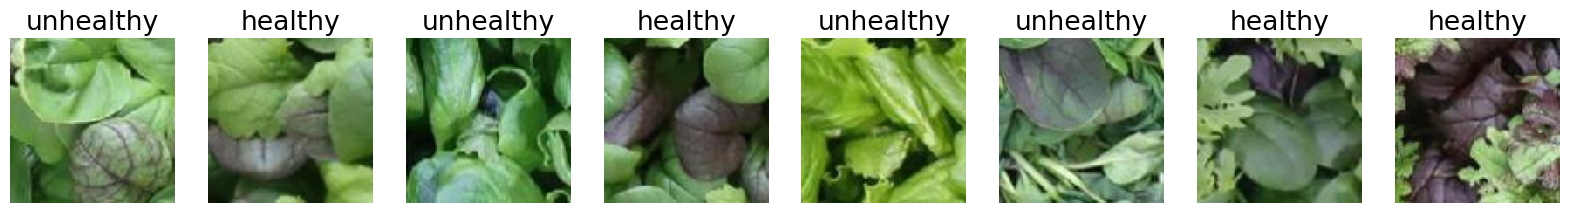

In [ ]:
# randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_unique.shape[0])
    ax[i].imshow(data_unique[random_index])
    ax[i].set_title(labels_unique[random_index])
    ax[i].axis('off')
plt.show()

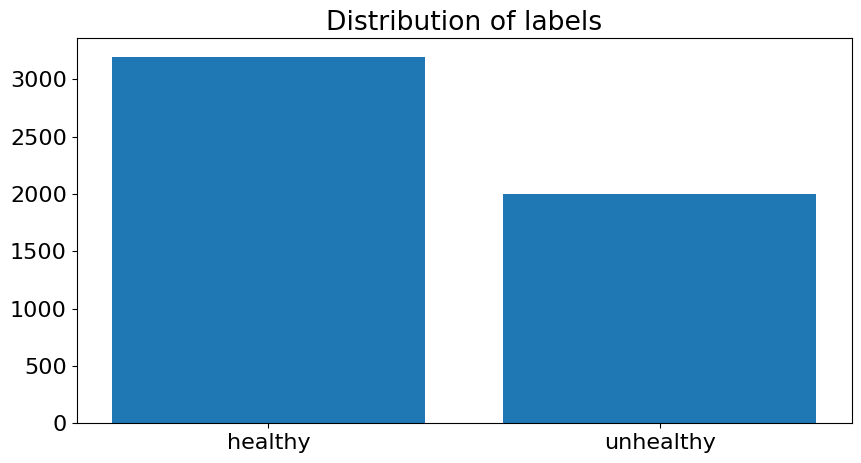

In [ ]:
from collections import Counter

counter_labels = Counter(labels)
labels_count, counts = zip(*counter_labels.items())

plt.figure(figsize=(10, 5))
plt.bar(labels_count, counts)
plt.title('Distribution of labels')
plt.show()

In [ ]:
# UPSAMLING
# Find the indices of the healthy and unhealthy images
healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

# Determine the number of images to sample from the unhealthy class to match the healthy class
num_samples = len(healthy_indices)

random_unhealthy_indices = np.random.choice(unhealthy_indices, size=(num_samples - len(unhealthy_indices)), replace=True)
random_unhealthy_images = data_unique[random_unhealthy_indices]
random_unhealthy_labels = labels_unique[random_unhealthy_indices]

# perform horizontal and vertical flipping and a 0.3 angle rotation on random_unhealthy_images
flip = tf.keras.Sequential([tfkl.RandomFlip("horizontal"), tfkl.RandomFlip("vertical"), tfkl.RandomRotation(0.3)])
random_unhealthy_images = np.array(flip(random_unhealthy_images), dtype=np.uint8)

# Concatenate the random unhealthy images and labels with the labels_unique and data_unique
data_balanced = np.concatenate([data_unique, random_unhealthy_images])
labels_balanced = np.concatenate([labels_unique, random_unhealthy_labels])

# Shuffle the data and labels so that the labels still correspond to the data
indices = np.arange(data_balanced.shape[0])
np.random.shuffle(indices)
data_balanced = data_balanced[indices]
labels_balanced = labels_balanced[indices]

print(data_balanced.shape)
print(labels_balanced.shape)

In [ ]:
# DOWNSAMPLING
# Find the indices of the healthy and unhealthy images
healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

# Determine the number of images to sample from the healthy class to match the unhealthy class
num_samples = len(unhealthy_indices)

# Downsample the healthy class if necessary
if len(healthy_indices) > num_samples:
    healthy_downsampled_indices = np.random.choice(healthy_indices, size=num_samples, replace=False)
    new_indices = np.concatenate([healthy_downsampled_indices, unhealthy_indices])
else:
    new_indices = np.concatenate([healthy_indices, unhealthy_indices])

# Use the new indices to create your balanced dataset
data_balanced = data_unique[new_indices]
labels_balanced = labels_unique[new_indices]

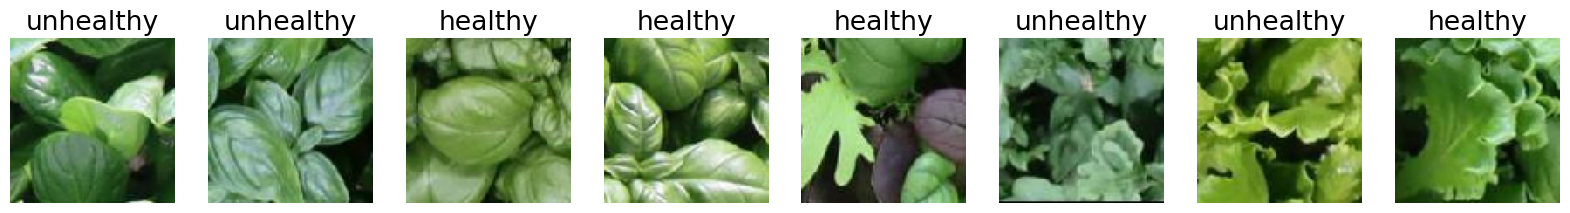

In [ ]:
# Randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_balanced.shape[0])
    ax[i].imshow(data_balanced[random_index])
    ax[i].set_title(labels_balanced[random_index])
    ax[i].axis('off')
plt.show()

In [ ]:
# Convert labels to one-hot encoding
label_mapping = {'healthy': 0, 'unhealthy': 1}
numeric_labels = [label_mapping[label] for label in labels_balanced]
one_hot_labels = np.array(numeric_labels)

# DATA SET SPLITTING

In [ ]:
# Split the data into train_val and test sets with stratification to ensure that the distribution of labels is the same in both sets
train_val_data, test_data, train_val_labels, test_labels = train_test_split(data_balanced, one_hot_labels, test_size=0.15, random_state=seed, stratify=one_hot_labels)
#train_data, val_data, train_labels, val_labels = train_test_split(data_balanced, one_hot_labels, test_size=0.15, random_state=seed, stratify=one_hot_labels)


# Further split the train_val set into train and val sets with stratification
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=len(test_data), random_state=seed, stratify=train_val_labels)

# Print the shape of the train, val and test sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
#print(test_data.shape, test_labels.shape)

(3041, 96, 96, 3) (3041,)
(537, 96, 96, 3) (537,)


#CONVNEXTLARGE MODEL

785596384/785596384 [==============================] - 5s 0us/step


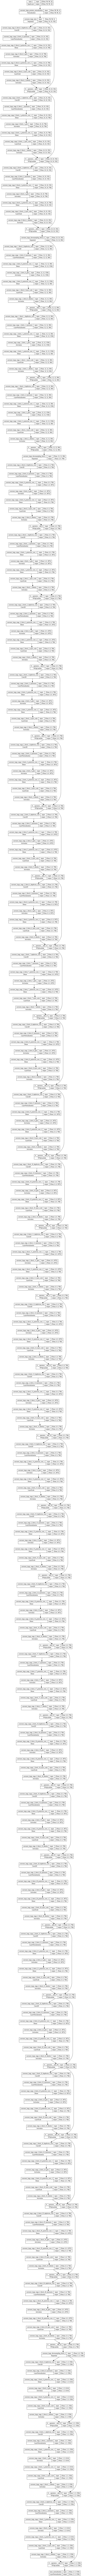

In [ ]:
# Define the input shape, output shape, batch size and the number of epochs
input_shape = train_data.shape[1:]
output_shape = len(np.unique(one_hot_labels))
batch_size = 16
epochs = 70

convNeXt_model = tfk.applications.ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=input_shape)

# Display the model architecture with input shapes
tfk.utils.plot_model(convNeXt_model, show_shapes=True)

In [ ]:
data_augmentation = tfk.Sequential([
    #tfkl.Rescaling(1./255),
    tfkl.RandomFlip("horizontal_and_vertical"),
    #tfkl.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    #tfkl.RandomBrightness(0.2, seed=seed),
    #tfkl.RandomContrast(0.2, seed=seed)
], name = "data_augmentation")

In [ ]:
model = tfk.Sequential([
    tfkl.Input(shape=input_shape),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.convnext.preprocess_input, name='supernet_preprocessing'),
    convNeXt_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.39),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed)),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed), name='output_layer')
], name='ConvNeXtLarge')

# Compile the model for binary classification
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
              loss=tfk.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "ConvNeXtLarge"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 96, 96, 3)         0         
 ial)                                                            
                                                                 
 supernet_preprocessing (La  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dropout (Dropout)           (None, 13824)             0         
                                                     

In [ ]:
# Prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.5, min_lr=5e-5, verbose=1)

callbacks = [rlrop, early_stopping]

In [ ]:
# Train the model
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (val_data, val_labels),
    shuffle = True,
    callbacks = callbacks
    #callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

# Save the trained model
model.save('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/ConvNeXtLarge-down')

Epoch 1/70
96/96 [==============================] - 177s 930ms/step - loss: 146.7475 - accuracy: 0.7047 - val_loss: 123.4333 - val_accuracy: 0.8026 - lr: 1.0000e-04
Epoch 2/70
96/96 [==============================] - 68s 711ms/step - loss: 101.5053 - accuracy: 0.8448 - val_loss: 79.7641 - val_accuracy: 0.7914 - lr: 1.0000e-04
Epoch 3/70
96/96 [==============================] - 66s 689ms/step - loss: 61.9017 - accuracy: 0.8819 - val_loss: 45.5759 - val_accuracy: 0.9199 - lr: 1.0000e-04
Epoch 4/70
96/96 [==============================] - 68s 706ms/step - loss: 34.5789 - accuracy: 0.9122 - val_loss: 25.2455 - val_accuracy: 0.9088 - lr: 1.0000e-04
Epoch 5/70
96/96 [==============================] - 66s 689ms/step - loss: 19.7083 - accuracy: 0.9411 - val_loss: 15.4025 - val_accuracy: 0.9348 - lr: 1.0000e-04
Epoch 6/70
96/96 [==============================] - 68s 706ms/step - loss: 12.8105 - accuracy: 0.9487 - val_loss: 10.8300 - val_accuracy: 0.9013 - lr: 1.0000e-04
Epoch 7/70
96/96 [======

In [ ]:
model = tfk.models.load_model('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/ConvNeXtLarge')

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

# evaluate f1 score, precision and recall
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = model.predict(test_data)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f"F1 score: {f1_score(test_labels, y_pred):.2f}")
print(f"Precision: {precision_score(test_labels, y_pred):.2f}")
print(f"Recall: {recall_score(test_labels, y_pred):.2f}")

## Fine-tuning

In [ ]:
ft_model = tfk.models.load_model('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/ConvNeXtLarge')

ft_model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
              loss=tfk.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
ft_model.set_weights(ft_model.get_weights())
ft_model.summary()
print("Number of layers in the base model: ", len(ft_model.get_layer(convNeXt_model.name).layers))

Model: "ConvNeXtLarge"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 96, 96, 3)         0         
 ial)                                                            
                                                                 
 supernet_preprocessing (La  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dropout (Dropout)           (None, 13824)             0         
                                                     

In [ ]:
# Unfreeze layers
ft_model.get_layer(convNeXt_model.name).trainable = True

unfreezed = 0
for i in reversed(range(len(ft_model.get_layer(convNeXt_model.name).layers))):
    layer = ft_model.get_layer(convNeXt_model.name).layers[i]
    if unfreezed < 670 and not isinstance(layer, tfk.layers.BatchNormalization):
        unfreezed += 1
        layer.trainable = True
    else:
        layer.trainable = False
    print(i, layer.name, layer.trainable)

ft_model.summary()

294 layer_normalization True
293 tf.__operators__.add_35 True
292 convnext_large_stage_3_block_2_identity True
291 convnext_large_stage_3_block_2_layer_scale True
290 convnext_large_stage_3_block_2_pointwise_conv_2 True
289 convnext_large_stage_3_block_2_gelu True
288 convnext_large_stage_3_block_2_pointwise_conv_1 True
287 convnext_large_stage_3_block_2_layernorm True
286 convnext_large_stage_3_block_2_depthwise_conv True
285 tf.__operators__.add_34 True
284 convnext_large_stage_3_block_1_identity True
283 convnext_large_stage_3_block_1_layer_scale True
282 convnext_large_stage_3_block_1_pointwise_conv_2 True
281 convnext_large_stage_3_block_1_gelu True
280 convnext_large_stage_3_block_1_pointwise_conv_1 True
279 convnext_large_stage_3_block_1_layernorm True
278 convnext_large_stage_3_block_1_depthwise_conv True
277 tf.__operators__.add_33 True
276 convnext_large_stage_3_block_0_identity True
275 convnext_large_stage_3_block_0_layer_scale True
274 convnext_large_stage_3_block_0_pointw

In [ ]:
ft_model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
              loss=tfk.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 4, factor= 0.5, min_lr= 5e-5, verbose=1)

callbacks = [rlrop, early_stopping]

In [ ]:
ft_history = ft_model.fit(
    x = train_data,
    y = train_labels,
    batch_size = batch_size,
    epochs = 70,
    validation_data = (val_data, val_labels),
    shuffle = True,
    callbacks = callbacks
).history

Epoch 1/70
96/96 [==============================] - 166s 946ms/step - loss: 0.0425 - accuracy: 0.9990 - val_loss: 0.3950 - val_accuracy: 0.9255 - lr: 1.0000e-05
Epoch 2/70
96/96 [==============================] - 68s 704ms/step - loss: 0.0362 - accuracy: 0.9987 - val_loss: 0.3972 - val_accuracy: 0.9255 - lr: 1.0000e-05
Epoch 3/70
96/96 [==============================] - 66s 690ms/step - loss: 0.0380 - accuracy: 0.9993 - val_loss: 0.4113 - val_accuracy: 0.9199 - lr: 1.0000e-05
Epoch 4/70
96/96 [==============================] - 69s 716ms/step - loss: 0.0355 - accuracy: 0.9993 - val_loss: 0.3957 - val_accuracy: 0.9218 - lr: 1.0000e-05
Epoch 5/70
96/96 [==============================] - 66s 685ms/step - loss: 0.0340 - accuracy: 0.9997 - val_loss: 0.4001 - val_accuracy: 0.9218 - lr: 1.0000e-05
Epoch 6/70
96/96 [==============================] - 67s 704ms/step - loss: 0.0344 - accuracy: 0.9997 - val_loss: 0.4088 - val_accuracy: 0.9218 - lr: 1.0000e-05
Epoch 7/70
96/96 [=====================

In [ ]:
ft_model.save('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/ft_ConvNeXtLarge')

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = ft_model.evaluate(test_data, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")
# evaluate f1 score, precision and recall
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = ft_model.predict(test_data)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f"F1 score: {f1_score(test_labels, y_pred):.2f}")
print(f"Precision: {precision_score(test_labels, y_pred):.2f}")
print(f"Recall: {recall_score(test_labels, y_pred):.2f}")

NameError: ignored